In [2]:
from sicore import truncated_cdf
from scipy.stats import norm

print(truncated_cdf(norm(), 1.4, [[-1, 3]]))

0.9054675616312214


100%|██████████| 400/400 [00:10<00:00, 37.85it/s]


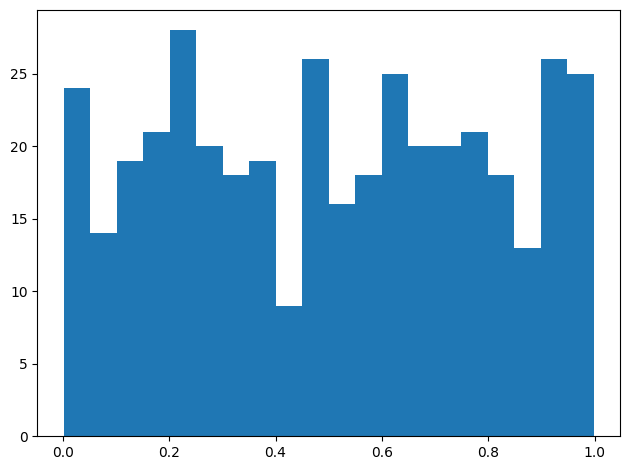

In [3]:
import numpy as np
from sicore import RealSubset, SelectiveInferenceNorm, linear_polynomials_below_zero, SelectiveInferenceResult
from tqdm import tqdm
import matplotlib.pyplot as plt

class MarginalScreeningNorm:
    """A class for marginal screening."""

    def __init__(self, X: np.ndarray, y: np.ndarray, sigma: float, k: int) -> None:
        self.X, self.y, self.sigma, self.k = X, y, sigma, k
        self.M = self._feature_selection(X, y, k)

    def _feature_selection(self, X: np.ndarray, y: np.ndarray, k: int) -> list[int]:
        return np.argsort(np.abs(X.T @ y))[::-1][:k].tolist()

    def algorithm(
        self,
        a: np.ndarray,
        b: np.ndarray,
        z: float,
    ) -> tuple[list[int], RealSubset]:
        a, b = self.X.T @ a, self.X.T @ b

        signs = np.sign(a + b * z)
        intervals_ = linear_polynomials_below_zero(-signs * a, -signs * b)
        intervals = RealSubset(intervals_)
        a, b = signs * a, signs * b

        collerations = a + b * z
        indexes = np.argsort(collerations)[::-1]

        active_set = indexes[: self.k]
        inactive_set = indexes[self.k :]

        for active in active_set:
            temp_intervals = linear_polynomials_below_zero(
                a[inactive_set] - a[active],
                b[inactive_set] - b[active],
            )
            intervals = intervals & RealSubset(temp_intervals)

        if z not in intervals:
            raise ValueError
        return indexes[: self.k].tolist(), intervals

    def model_selector(self, M: list[int]) -> bool:
        return set(self.M) == set(M)

    def inference(
        self,
        index: int,
    ) -> SelectiveInferenceResult:
        eta = self.construct_eta(index)
        self.si = SelectiveInferenceNorm(self.y, self.sigma, eta)
        return self.si.inference(
            self.algorithm,
            self.model_selector,
        )

    def construct_eta(self, index: int) -> np.ndarray:
        return (
            self.X[:, self.M]
            @ np.linalg.inv(self.X[:, self.M].T @ self.X[:, self.M])[:, index]
        )


rng = np.random.default_rng(0)
n, p, k = 100, 10, 3

p_list = []

for _ in tqdm(range(400)):
    X = rng.normal(size=(n, p))
    y = rng.normal(size=n)
    sigma = 1.0
    ms = MarginalScreeningNorm(X, y, sigma, k)
    result = ms.inference(rng.integers(k))
    p_list.append(result.p_value)

plt.hist(p_list, bins=20)
plt.show()

In [4]:
from scipy.stats import rv_continuous
from scipy.special import logsumexp

def compute_log_area(rv: rv_continuous, intervals: RealSubset) -> float:
    """Compute the logarithm of the integral of the pdf over the each interval.

    Parameters
    ----------
    rv : rv_continuous
        The rv_continuous instance to be integrated.
    intervals : RealSubset
        The intervals on which to compute the integral.

    Returns
    -------
    float
        The logarithm of the integral.
    """
    left_ends, right_ends = intervals.intervals.T
    log_each_area = np.empty(len(intervals))
    mask = left_ends < rv.median()

    left_log_cdf, right_log_cdf = (
        rv.logcdf(left_ends[mask]),
        rv.logcdf(right_ends[mask]),
    )
    log_each_area[mask] = right_log_cdf + _log1mexp(left_log_cdf - right_log_cdf)

    left_log_sf, right_log_sf = rv.logsf(left_ends[~mask]), rv.logsf(right_ends[~mask])
    log_each_area[~mask] = left_log_sf + _log1mexp(right_log_sf - left_log_sf)

    return logsumexp(log_each_area)


def _log1mexp(z: np.ndarray) -> np.ndarray:
    """Compute the logarithm of one minus the exponential of the input array, element-wise.

    Parameters
    ----------
    z : np.ndarray
        Input values.

    Returns
    -------
    np.ndarray
        Logarithm of one minus the exponential of the input array.
    """
    z = np.asarray(z)
    values = np.empty_like(z)
    halflog = -0.693147  # equal to log(0.5)
    mask = z < halflog
    values[mask] = np.log1p(-np.exp(z[mask]))
    values[~mask] = np.log(-np.expm1(z[~mask]))
    return values

In [5]:
rng = np.random.default_rng(0)
n, p, k = 100, 10, 3

X = rng.normal(size=(n, p))
y = rng.normal(size=n)
sigma = 1.0
ms = MarginalScreeningNorm(X, y, sigma, k)
print(ms.M)
result = ms.inference(rng.integers(k))
print(result)

[0, 2, 1]
stat: 1.995830
p_value: 0.124871
inf_p: 0.124871
sup_p: 0.124894
searched_intervals: [[-4.498807, 4.367511]]
truncated_intervals: [[-4.498807, -1.010253], [0.800383, 4.367511]]
search_count: 6
detect_count: 3
null_rv: norm
alternative: two-sided


In [6]:
from scipy.integrate import quad

rng = np.random.default_rng(0)
n, p, k = 100, 10, 3

tau = 0.2
omega = rng.normal(size=n, scale=tau)
ms = MarginalScreeningNorm(X, y + omega, (sigma ** 2 + tau ** 2) ** 0.5, k)
print(ms.M)
eta = ms.construct_eta(0)
si = SelectiveInferenceNorm(y + omega, (sigma ** 2 + tau ** 2) ** 0.5, eta)
result = si.inference(ms.algorithm, ms.model_selector, inference_mode="exhaustive")
print(result)

region = result.truncated_intervals

si_ = SelectiveInferenceNorm(y, sigma, eta)
stat_orig = si_.stat
print(stat_orig)

rho_sq = tau**2 / (sigma**2 + tau**2)
null = 0.0

log_denom = compute_log_area(norm(), RealSubset(region))
print(log_denom)
def integrand(v):
    log_nom = norm.logcdf(stat_orig, loc=rho_sq * null + (1 - rho_sq) * v, scale=sigma * (rho_sq)**0.5)
    return np.exp(norm.logpdf(v) + log_nom - log_denom)

pivot = 0.0
for interval in region:
    a, b = interval
    if b < stat_orig:
        pivot += quad(integrand, a, b)[0]
    elif a < stat_orig:
        pivot += quad(integrand, a, stat_orig)[0]
print(2 * min(pivot, 1 - pivot))


[0, 2, 1]
stat: 1.800473
p_value: 0.207969
inf_p: 0.207969
sup_p: 0.207969
searched_intervals: [[-12.250915, 29.124837]]
truncated_intervals: [[-3.095695, -1.039048], [0.870380, 7.677439]]
search_count: 12
detect_count: 4
null_rv: norm
alternative: two-sided
1.9958295537871589
-1.0774695226089561
0.1541184730261964


100%|██████████| 1000/1000 [00:42<00:00, 23.76it/s]


0.4
0.852
0.628


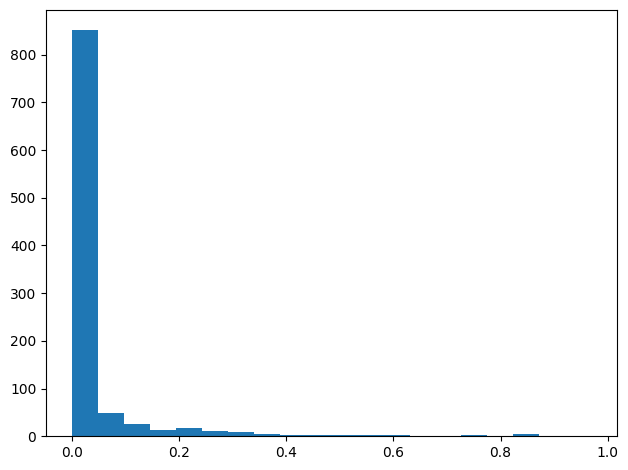

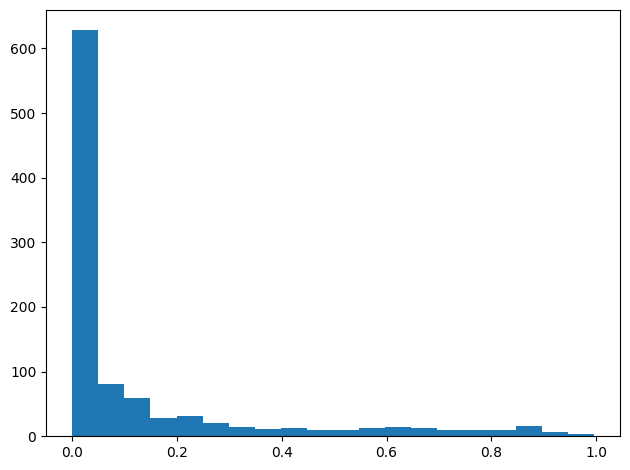

In [34]:
rng = np.random.default_rng(42)
n, d, k = 100, 10, 3
sigma = 1.0
tau = 1.0

delta = 0.4
beta = delta * np.ones(d)

p_list_orig = []
p_list = []

for _ in tqdm(range(1000)):
    X = rng.normal(size=(n, d))
    y = X @ beta + rng.normal(size=n)
    omega = rng.normal(size=n, scale=tau)

    ms = MarginalScreeningNorm(X, y, sigma, k)
    p_list_orig.append(ms.inference(rng.integers(k)).p_value)


    ms = MarginalScreeningNorm(X, y + omega, None, k)
    eta = ms.construct_eta(rng.integers(k))
    si = SelectiveInferenceNorm(y + omega, (sigma ** 2 + tau ** 2), eta)
    result = si.inference(ms.algorithm, ms.model_selector, inference_mode="exhaustive")

    region = result.truncated_intervals
    region = RealSubset(np.array(region) * np.sqrt(sigma**2 + tau**2))

    si_ = SelectiveInferenceNorm(y, sigma**2, eta)
    stat_orig = si_.stat * sigma

    rho_sq = tau**2 / (sigma**2 + tau**2)
    null = 0.0

    log_denom = compute_log_area(norm(scale=(sigma ** 2 + tau** 2)**0.5), region)
    def integrand(v):
        log_nom = norm.logcdf(stat_orig, loc=rho_sq * null + (1 - rho_sq) * v, scale=sigma * (rho_sq)**0.5)
        return np.exp(norm.logpdf(v, scale=(sigma ** 2 + tau ** 2)**0.5) + log_nom - log_denom)

    pivot = 0.0
    for interval in region:
        a, b = interval
        pivot += quad(integrand, a, b)[0]
        # if b < stat_orig:
            # pivot += quad(integrand, a, b)[0]
        # elif a < stat_orig:
            # pivot += quad(integrand, a, stat_orig)[0]
    p_randomized = 2 * min(pivot, 1 - pivot)

    p_list.append(p_randomized)


print(delta)
print(np.mean(np.array(p_list) < 0.05))
print(np.mean(np.array(p_list_orig) < 0.05))

plt.hist(p_list, bins=20)
plt.show()

plt.hist(p_list_orig, bins=20)
plt.show()

In [37]:
def ci(fpr_list:np.ndarray) -> np.ndarray:
    temp = []
    for fpr in fpr_list:
        temp.append(norm.ppf(1 - 0.05 / 2) * (fpr * (1 - fpr) / 1000)**0.5)
    return np.array(temp)

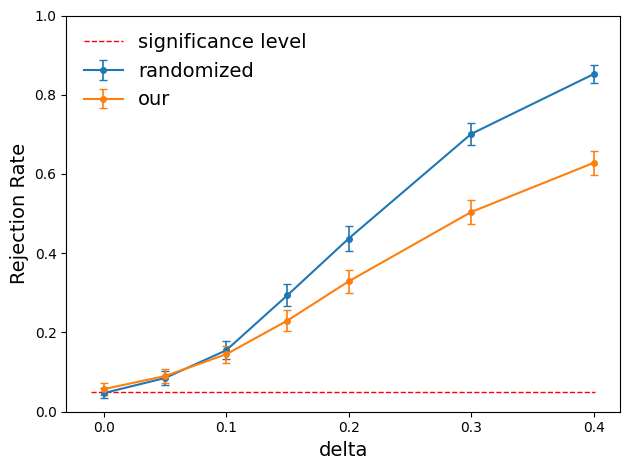

In [50]:
import matplotlib.pyplot as plt
from sicore import SummaryFigure

signals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
fpr_list_r = [0.047, 0.085, 0.155, 0.294, 0.437, 0.701, 0.852]
fpr_list_o = [0.057, 0.09, 0.145, 0.23, 0.329, 0.504, 0.628]

plt.errorbar(signals, fpr_list_r, yerr=ci(np.array(fpr_list_r)), label="randomized", fmt="o-",                     capsize=3,
                    markersize=4,
                    elinewidth=1.2,)
plt.errorbar(signals, fpr_list_o, yerr=ci(np.array(fpr_list_o)), label="our", fmt="o-",                     capsize=3,
                    markersize=4,
                    elinewidth=1.2,)
plt.xlabel("delta", fontsize=14)  # delta is the signal amplitude, see the code exam
plt.ylabel("Rejection Rate", fontsize=14)
plt.ylim(0, 1)
plt.hlines(y=0.05, xmin=-0.01, xmax=0.401, colors="red", linestyles="dashed", linewidth=1, label="significance level")
plt.legend(frameon=False, fontsize=14)
plt.savefig("randomized.pdf", bbox_inches="tight", pad_inches=0.0, transparent=True)